## 1. Data Load

In [9]:
import pickle

with open("mon_standard.pkl", 'rb') as fi:
    mon_data = pickle.load(fi)
    

with open("unmon_standard10_3000.pkl", 'rb') as fi:
    unmon_data = pickle.load(fi)
    
print("Data has been successfully loaded.")

Data has been successfully loaded.


## 2. Data Preprocess

In [10]:
# Monitored
def process_monitored(data, total_urls=950, use_sublabel=False, url_per_site=10):
    X1, X2, y = [], [], []
    for i in range(total_urls):
        label = i if use_sublabel else i // url_per_site
        for sample in data[i]:
            size_seq = []
            time_seq = []
            for c in sample:
                dr = 1 if c > 0 else -1
                time_seq.append(abs(c))
                size_seq.append(dr * 512)
            X1.append(time_seq)
            X2.append(size_seq)
            y.append(label)
    return X1, X2, y

# Unmonitored
def process_unmonitored(data, total_urls=3000):
    X1, X2 = [], []
    for i in range(total_urls):
        size_seq = []
        time_seq = []
        for c in data[i]:
            dr = 1 if c > 0 else -1
            time_seq.append(abs(c))
            size_seq.append(dr * 512)
        X1.append(time_seq)
        X2.append(size_seq)
    y = [-1] * len(X1) 
    return X1, X2, y

# Monitored
X1_mon, X2_mon, y_mon = process_monitored(
    mon_data, total_urls=950, use_sublabel=False, url_per_site=10
)

# Unmonitored
X1_unmon, X2_unmon, y_unmon = process_unmonitored(
    unmon_data, total_urls=3000
)


X1 = X1_mon + X1_unmon
X2 = X2_mon + X2_unmon
y = y_mon + y_unmon

## 3. Feature Extraction

In [11]:
import numpy as np
from itertools import groupby

# Initialize a list to store all features
features = []

# Feature extraction
for i in range(len(X2)):
    size_seq = X2[i]
    time_seq = X1[i]
    
    # 1. Number of incoming packets
    num_incoming_packets = sum(1 for size in size_seq if size < 0)
    
    # 2. Total number of packets
    num_total_packets = len(size_seq)
    
    # 3. Number of outgoing packets
    num_outgoing_packets = sum(1 for size in size_seq if size > 0)
    
    # 4. Proportion of outgoing packets
    ratio_outgoing = num_outgoing_packets / num_total_packets if num_total_packets > 0 else 0
    
    # 5. Proportion of incoming packets
    ratio_incoming = num_incoming_packets / num_total_packets if num_total_packets > 0 else 0
    
    # 6. Proportion of incoming packets in the first 30 packets
    incoming_first_30 = sum(1 for size in size_seq[:30] if size < 0) / 30 if num_total_packets >= 30 else 0
    
    # 7. Proportion of outgoing packets in the first 30 packets
    outgoing_first_30 = sum(1 for size in size_seq[:30] if size > 0) / 30 if num_total_packets >= 30 else 0
    
    # 8. Maximum number of packets in outgoing bursts
    burst_outgoing_max = max(len(list(g)) for k, g in groupby(size_seq) if k > 0) if num_outgoing_packets > 0 else 0
    
    # 9. Standard deviation of outgoing burst sizes
    outgoing_burst_std = np.std([len(list(g)) for k, g in groupby(size_seq) if k > 0])
    
    # 10. Average size of outgoing bursts
    outgoing_burst_avg = np.mean([len(list(g)) for k, g in groupby(size_seq) if k > 0])
    
    # 11. Number of outgoing bursts
    num_outgoing_bursts = len([1 for k, g in groupby(size_seq) if k > 0])
    
    # 12. Number of incoming bursts
    num_incoming_bursts = len([1 for k, g in groupby(size_seq) if k < 0])
    
    # 13. Average number of incoming packets per second
    incoming_per_second_avg = num_incoming_packets / (len(time_seq) / 60) if len(time_seq) > 0 else 0

    # 14. Total transmission time
    total_time = sum(time_seq)

    # 15. Average time interval in the last 5 seconds
    last_5_seconds_time_intervals = np.mean([time_seq[i+1] - time_seq[i] for i in range(len(time_seq)-1) if time_seq[i] > 0]) if len(time_seq) > 1 else 0
    
    # 16. Sum of packet sizes
    sum_packets = sum(size_seq)
    
    # 17. Packets per second
    packets_per_second = len(size_seq) / sum(time_seq) if sum(time_seq) > 0 else 0
    
    # 18. Mean packets per second
    packets_per_second_values = [1 / t for t in time_seq if t > 0]
    
    # 19. mean of the packets per second values
    mean_packets_per_second = np.mean(packets_per_second_values) if packets_per_second_values else 0
    
    # 20. Standard deviation of packets per second
    std_packets_per_second = np.std(packets_per_second_values) if packets_per_second_values else 0
    
    # 21. Transmission time Q1 (25th percentile)
    transmission_time_Q1 = np.percentile(time_seq, 25) if len(time_seq) > 0 else 0
    
    # 22. Transmission time Q2 (median)
    transmission_time_Q2 = np.percentile(time_seq, 50) if len(time_seq) > 0 else 0
    
    # 23. Transmission time Q3 (75th percentile)
    transmission_time_Q3 = np.percentile(time_seq, 75) if len(time_seq) > 0 else 0
    
    # 24. Transmission time Q4 (maximum)
    transmission_time_Q4 = np.percentile(time_seq, 100) if len(time_seq) > 0 else 0
    
    # 25. Average ordering of outgoing packets
    outgoing_order = [i for i, size in enumerate(size_seq) if size > 0]
    average_outgoing_ordering = np.mean(outgoing_order) if outgoing_order else 0
    
    # 26. Standard deviation of outgoing packet ordering
    std_dev_outgoing_ordering = np.std(outgoing_order) if outgoing_order else 0
    
    # Add all features to the list
    features.append([
        num_incoming_packets, num_total_packets, num_outgoing_packets, ratio_outgoing,
        ratio_incoming, incoming_first_30, outgoing_first_30, burst_outgoing_max,
        outgoing_burst_std, outgoing_burst_avg, num_outgoing_bursts,
        num_incoming_bursts, incoming_per_second_avg,  total_time,
        last_5_seconds_time_intervals, 
        sum_packets, packets_per_second, mean_packets_per_second, std_packets_per_second,
        transmission_time_Q1, transmission_time_Q2, transmission_time_Q3, transmission_time_Q4,
        average_outgoing_ordering, std_dev_outgoing_ordering
    ])

# Convert the feature list to a numpy array
features = np.array(features)

# Labels for each sample
y = np.array(y)

## 4. Data split and downsampling

In [12]:
# conda install -c conda-forge scikit-learn imbalanced-learn


In [13]:
pip uninstall imbalanced-learn scikit-learn -y


Found existing installation: imbalanced-learn 0.10.1
Uninstalling imbalanced-learn-0.10.1:
  Successfully uninstalled imbalanced-learn-0.10.1
Found existing installation: scikit-learn 1.2.2
Uninstalling scikit-learn-1.2.2:
  Successfully uninstalled scikit-learn-1.2.2
Note: you may need to restart the kernel to use updated packages.


In [14]:
!pip install scikit-learn==1.2.2 imbalanced-learn==0.10.1


  Using cached scikit_learn-1.2.2-cp311-cp311-macosx_12_0_arm64.whl.metadata (11 kB)
  Using cached imbalanced_learn-0.10.1-py3-none-any.whl.metadata (8.2 kB)
Using cached scikit_learn-1.2.2-cp311-cp311-macosx_12_0_arm64.whl (8.4 MB)
Using cached imbalanced_learn-0.10.1-py3-none-any.whl (226 kB)

[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


In [15]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
import pandas as pd
import numpy as np


X_train, X_test, y_train, y_test = train_test_split(features, y, test_size=0.2, random_state=42, stratify=y)


train_data = pd.DataFrame({
    'features': list(X_train),
    'label': y_train
})
train_monitored = train_data[train_data['label'] != -1]
train_unmonitored = train_data[train_data['label'] == -1]


X_train_list = np.array(train_data['features'].tolist())
y_train_array = train_data['label'].values

smote = SMOTE(random_state=42, sampling_strategy={-1: 15200})  
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_list, y_train_array)


scaler = StandardScaler()
X_train_balanced = scaler.fit_transform(X_train_balanced)
X_test = scaler.transform(X_test)


print("Balanced Training Data Distribution:")
print(pd.Series(y_train_balanced).value_counts())

print("Test Data Distribution:")
print(pd.Series(y_test).value_counts())


/opt/anaconda3/lib/python3.11/site-packages/imblearn/utils/_validation.py:313: UserWarning: After over-sampling, the number of samples (15200) in class -1 will be larger than the number of samples in the majority class (class #-1 -> 2400)
  warnings.warn(


Balanced Training Data Distribution:
-1     15200
 12      160
 73      160
 67      160
 52      160
       ...  
 82      160
 26      160
 23      160
 31      160
 81      160
Name: count, Length: 96, dtype: int64
Test Data Distribution:
-1     600
 6      40
 20     40
 62     40
 29     40
      ... 
 75     40
 28     40
 73     40
 34     40
 42     40
Name: count, Length: 96, dtype: int64


## 5. Train the Random Forest model

In [16]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(
    n_estimators=2000, 
    min_samples_split=5, 
    min_samples_leaf=2, 
    max_features=0.7, 
    max_depth=30, 
    class_weight='balanced' 
)

rf_model.fit(X_train_balanced, y_train_balanced)

RandomForestClassifier(class_weight='balanced', max_depth=30, max_features=0.7,
                       min_samples_leaf=2, min_samples_split=5,
                       n_estimators=2000)

## 6. Test and evaluate the model

In [17]:
from sklearn.metrics import accuracy_score, auc, confusion_matrix, precision_score, precision_recall_curve, roc_curve, recall_score, f1_score, classification_report

y_pred = rf_model.predict(X_test)

# calculate Accuracy, Precison, Recall, F1 Score
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average = 'weighted')
recall = recall_score(y_test, y_pred, average = 'weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

# calculate Confusion Matrix, ROC AUC, PR AUC 
conf_matrix = confusion_matrix(y_test, y_pred)

# create Classification Report
class_report = classification_report(y_test, y_pred, target_names=[f'Class {i}' for i in range(-1, 95)])

# print results
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision (Weighted): {precision:.4f}")
print(f"Recall (Weighted): {recall:.4f}")
print(f"F1 Score (Weighted): {f1:.4f}")

print(f"\nConfusion Matrix\n{conf_matrix}")
print("\nClassification Report:\n", class_report)

Accuracy: 0.7564
Precision (Weighted): 0.7806
Recall (Weighted): 0.7564
F1 Score (Weighted): 0.7567

Confusion Matrix
[[492   1   2 ...   3   0   3]
 [  5  28   0 ...   1   0   1]
 [  5   0  31 ...   0   0   0]
 ...
 [ 16   0   0 ...  16   0   0]
 [  2   0   0 ...   0  37   0]
 [  3   0   0 ...   0   0  25]]

Classification Report:
               precision    recall  f1-score   support

    Class -1       0.52      0.82      0.64       600
     Class 0       0.90      0.70      0.79        40
     Class 1       0.86      0.78      0.82        40
     Class 2       0.90      0.88      0.89        40
     Class 3       0.86      0.78      0.82        40
     Class 4       0.84      0.78      0.81        40
     Class 5       0.94      0.72      0.82        40
     Class 6       0.82      0.90      0.86        40
     Class 7       0.83      0.95      0.88        40
     Class 8       0.79      0.78      0.78        40
     Class 9       0.85      0.72      0.78        40
    Class 10    

In [18]:

print("\nOriginal Training Data Distribution:")
print(f"Label -1 count: {sum(y_train == -1)}")
print(f"Other labels count: {sum(y_train != -1)}")

print("\nBalanced Training Data Distribution:")
print(f"Label -1 count: {sum(y_train_balanced == -1)}")
print(f"Other labels count: {sum(y_train_balanced != -1)}")

print("\nTest Data Distribution:")
print(f"Label -1 count: {sum(y_test == -1)}")
print(f"Other labels count: {sum(y_test != -1)}")



Original Training Data Distribution:
Label -1 count: 2400
Other labels count: 15200

Balanced Training Data Distribution:
Label -1 count: 15200
Other labels count: 15200

Test Data Distribution:
Label -1 count: 600
Other labels count: 3800


## 7. Visualization

### 7.1 Data Distribution Before and After SMOTE

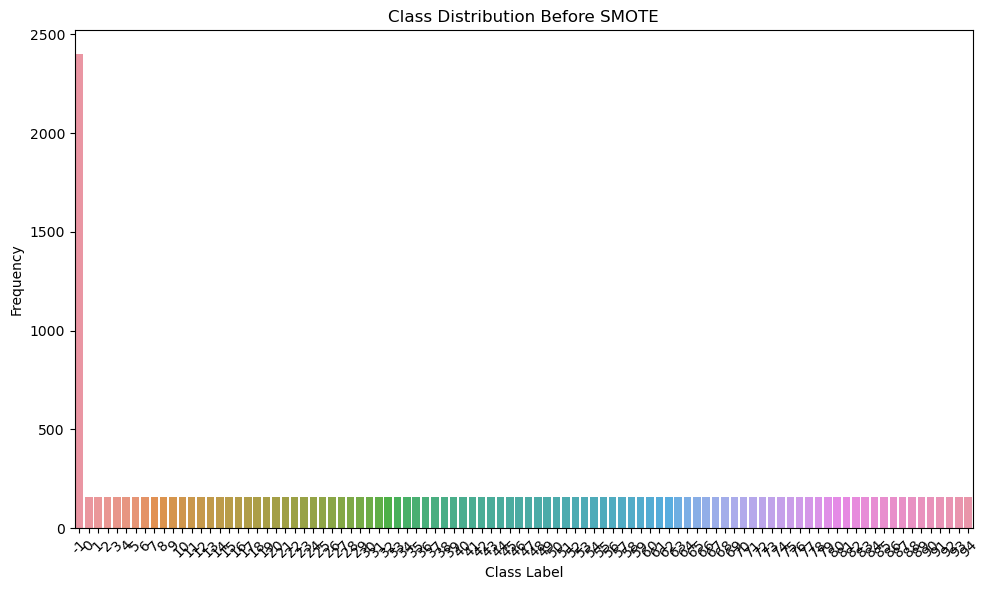

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt 

plt.figure(figsize=(10, 6))
sns.countplot(x=y_train, order=sorted(np.unique(y_train)))
plt.title('Class Distribution Before SMOTE')
plt.xlabel('Class Label')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


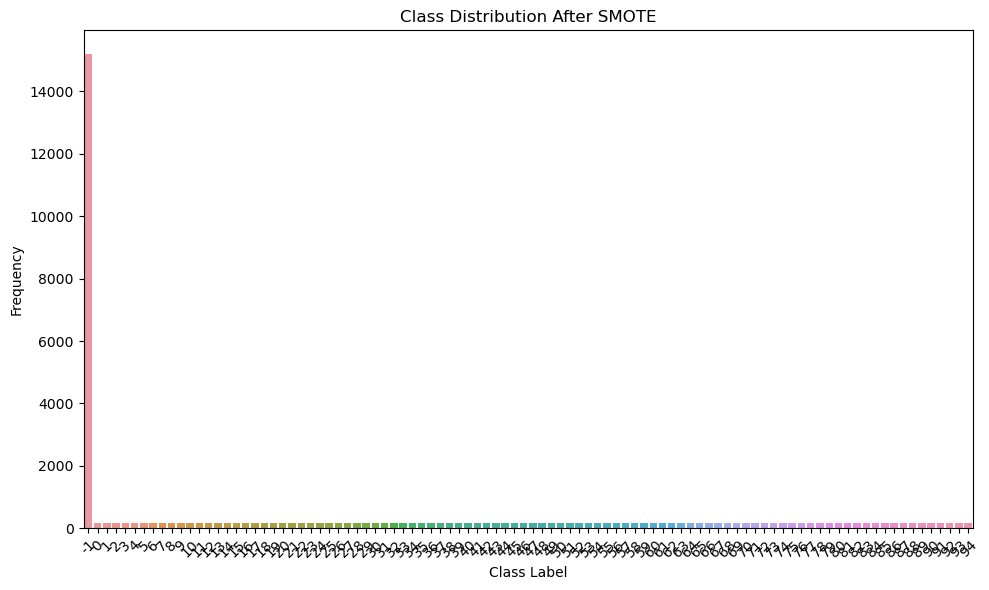

In [20]:

plt.figure(figsize=(10, 6))
sns.countplot(x=y_train_balanced, order=sorted(np.unique(y_train_balanced)))
plt.title('Class Distribution After SMOTE')
plt.xlabel('Class Label')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### 7.2 PR Curve

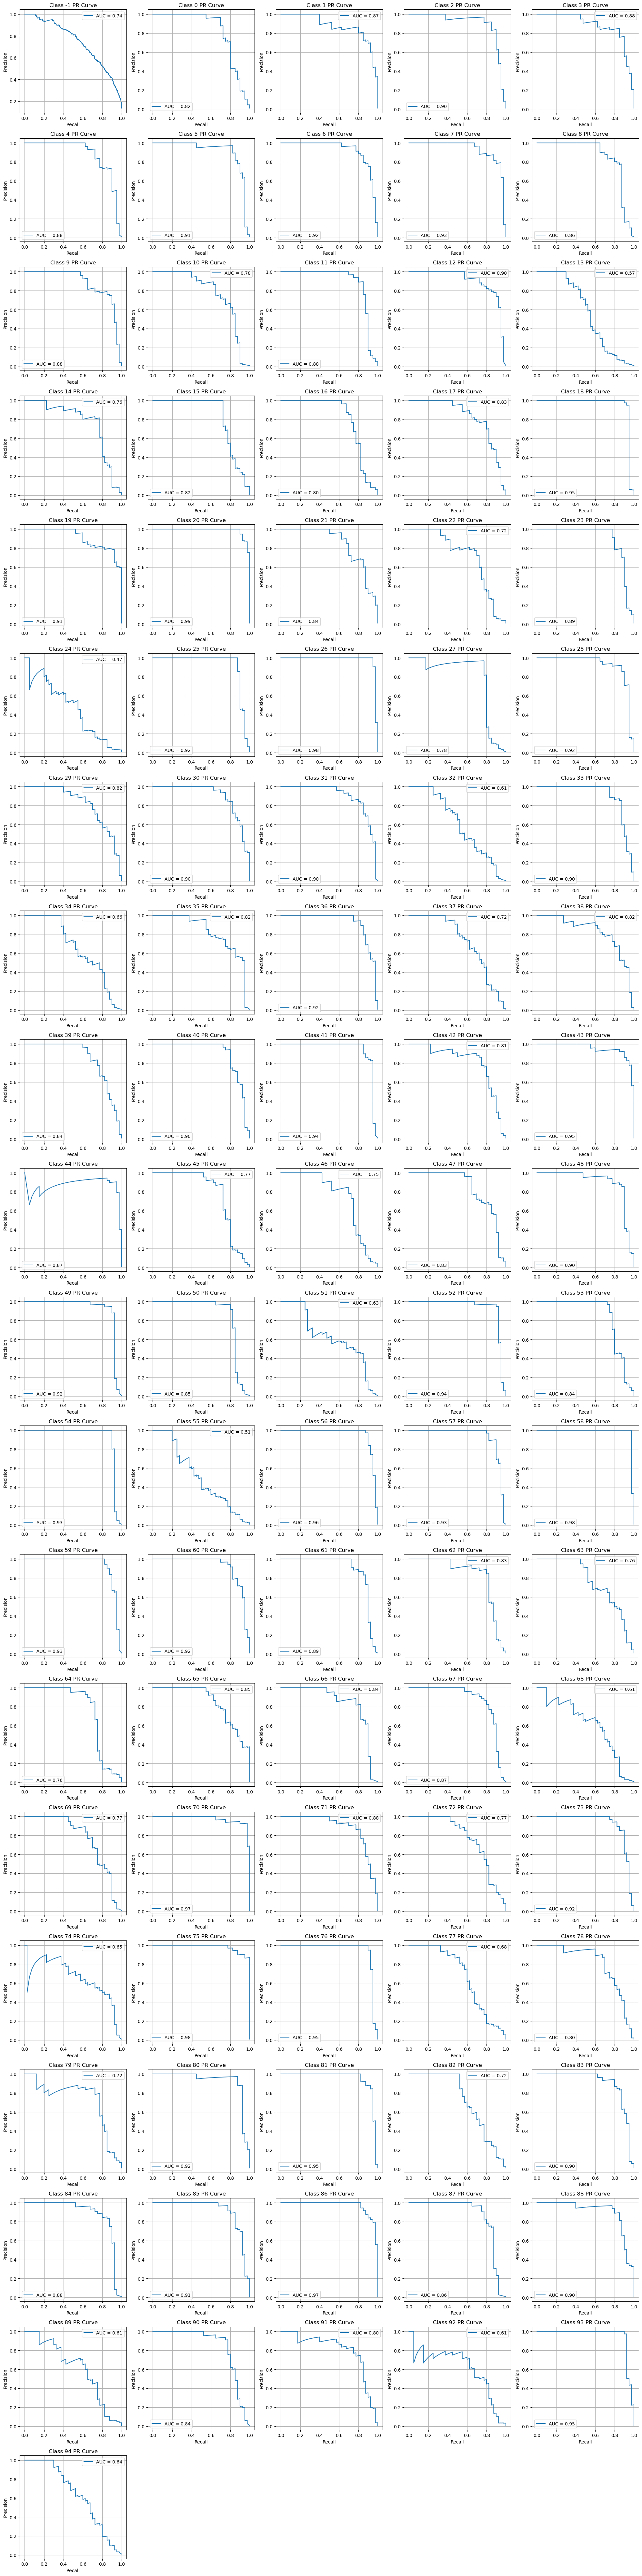

In [21]:
# Obtain the predicted probabilities for each class from the trained Random Forest model
y_scores = rf_model.predict_proba(X_test)

# Function to plot Precision-Recall (PR) curves for each class
def plot_pr_curve_per_class(y_test, y_scores, n_classes):
    """
    Plot Precision-Recall curves for each class in a multi-class classification task.

    """
    # Create subplots with a grid layout to accommodate all class PR curves
    fig, axes = plt.subplots(n_classes // 5 + 1, 5, figsize=(20, 4 * (n_classes // 5 + 1)))
    axes = axes.ravel()  # Flatten the axes array for easier indexing

    for i, class_label in enumerate(sorted(np.unique(y_test))):  # Iterate through each class
        # Compute precision and recall values for the current class
        precision, recall, _ = precision_recall_curve((y_test == class_label), y_scores[:, i])
        # Calculate the area under the Precision-Recall curve (AUC)
        pr_auc = auc(recall, precision)
        # Plot the PR curve for the current class
        axes[i].plot(recall, precision, label=f'AUC = {pr_auc:.2f}')
        axes[i].set_title(f'Class {class_label} PR Curve')  # Set the title for the current subplot
        axes[i].set_xlabel('Recall')  # Label the x-axis
        axes[i].set_ylabel('Precision')  # Label the y-axis
        axes[i].legend(loc='best')  # Add a legend showing the AUC value
        axes[i].grid(True)  # Enable grid for better readability

    # Turn off any remaining empty subplots
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')

    # Adjust layout to ensure subplots do not overlap
    plt.tight_layout()
    plt.show()

# Plot the PR curves for all classes
plot_pr_curve_per_class(y_test, y_scores, n_classes=len(np.unique(y_test)))



Class 95 has no samples in y_test. Skipping...


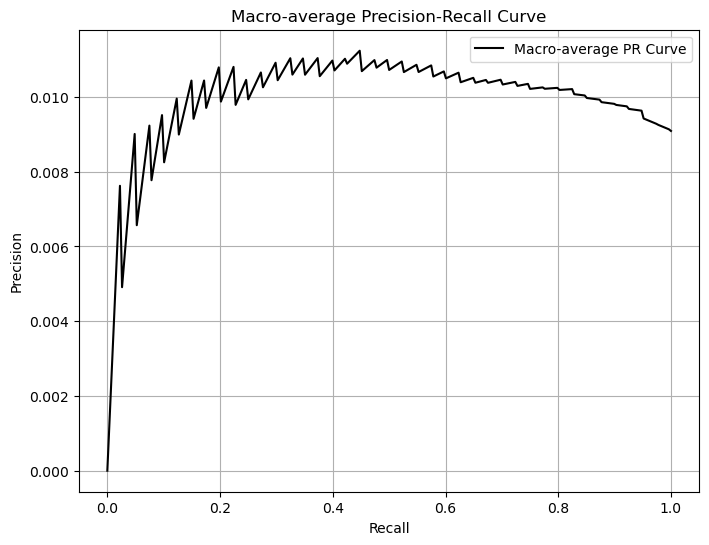

In [22]:

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve

def plot_macro_avg_pr_curve(y_test, y_scores, n_classes):
    """
    Plots the macro-average Precision-Recall (PR) curve for a multi-class classification task.

    """
    from sklearn.preprocessing import label_binarize  # For one-hot encoding of the labels

    # Binarize the ground truth labels (one-hot encoding for multi-class classification)
    y_test_bin = label_binarize(y_test, classes=np.arange(n_classes))

    # Initialize lists to store precision and recall for each class
    precision_list, recall_list = [], []
    min_len = float('inf')  # Track the minimum length of precision-recall arrays across all classes

    # Compute Precision-Recall curve for each class
    for i in range(n_classes):
        # Skip classes with no samples in the test set
        if np.sum(y_test == i) == 0:
            print(f"Class {i} has no samples in y_test. Skipping...")
            continue

        # Compute precision and recall for the current class
        precision, recall, _ = precision_recall_curve(y_test_bin[:, i], y_scores[:, i])
        # Update the minimum length for interpolation
        min_len = min(min_len, len(precision))
        # Append the precision and recall values for the current class
        precision_list.append(precision)
        recall_list.append(recall)

    # Initialize arrays for macro-average precision and recall
    avg_precision = np.zeros(min_len)
    avg_recall = np.linspace(0, 1, min_len)  # Uniform recall range for all classes

    # Interpolate and accumulate precision values for all classes
    for precision, recall in zip(precision_list, recall_list):
        interp_precision = np.interp(avg_recall, recall[::-1], precision[::-1])
        avg_precision += interp_precision

    # Compute the macro-average precision
    avg_precision /= len(precision_list)

    # Plot the macro-average Precision-Recall curve
    plt.figure(figsize=(8, 6))
    plt.plot(avg_recall, avg_precision, label='Macro-average PR Curve', color='black')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Macro-average Precision-Recall Curve')
    plt.legend(loc='best')
    plt.grid(True)
    plt.show()

# Define the number of classes
n_classes = 96
# Plot the macro-average Precision-Recall curve using the test labels and predicted probabilities
plot_macro_avg_pr_curve(y_test, rf_model.predict_proba(X_test), n_classes)


In [23]:

from sklearn.metrics import average_precision_score
import numpy as np

# Function to compute Precision-Recall AUC (PR AUC) for each class and the macro-average
def compute_pr_auc_open_multi(y_test, y_scores, n_classes):
    """
    Computes the Precision-Recall AUC (PR AUC) for each class and the macro-average PR AUC 
    in an open-world multi-class classification scenario.
    """
    pr_auc_per_class = []  # List to store PR AUC for each class

    for i in range(n_classes):
        # Determine the label for the current class
        label = -1 if i == n_classes - 1 else i  # Use -1 for the unmonitored class

        # Compute PR AUC for the current class
        pr_auc = average_precision_score(y_test == label, y_scores[:, i])
        pr_auc_per_class.append(pr_auc)

    # Compute macro-average PR AUC by taking the mean of all class PR AUC values
    macro_pr_auc = np.mean(pr_auc_per_class)

    return pr_auc_per_class, macro_pr_auc


# Determine the number of classes (monitored and unmonitored)
n_classes = len(np.unique(y_test))

# Compute PR AUC for each class and macro-average
pr_auc_per_class, macro_pr_auc = compute_pr_auc_open_multi(y_test, y_scores, n_classes)

# Print the PR AUC for each class and the macro-average
for i, auc_val in enumerate(pr_auc_per_class):
    class_label = -1 if i == n_classes - 1 else i  # Assign -1 to the unmonitored class
    print(f"Class {class_label} PR AUC: {auc_val:.4f}")
print(f"Macro-average PR AUC: {macro_pr_auc:.4f}")



Class 0 PR AUC: 0.0097
Class 1 PR AUC: 0.0081
Class 2 PR AUC: 0.0182
Class 3 PR AUC: 0.0089
Class 4 PR AUC: 0.0086
Class 5 PR AUC: 0.0093
Class 6 PR AUC: 0.0129
Class 7 PR AUC: 0.0125
Class 8 PR AUC: 0.0124
Class 9 PR AUC: 0.0101
Class 10 PR AUC: 0.0079
Class 11 PR AUC: 0.0082
Class 12 PR AUC: 0.0102
Class 13 PR AUC: 0.0102
Class 14 PR AUC: 0.0126
Class 15 PR AUC: 0.0163
Class 16 PR AUC: 0.0087
Class 17 PR AUC: 0.0084
Class 18 PR AUC: 0.0082
Class 19 PR AUC: 0.0089
Class 20 PR AUC: 0.0091
Class 21 PR AUC: 0.0092
Class 22 PR AUC: 0.0086
Class 23 PR AUC: 0.0085
Class 24 PR AUC: 0.0272
Class 25 PR AUC: 0.0116
Class 26 PR AUC: 0.0806
Class 27 PR AUC: 0.0090
Class 28 PR AUC: 0.0107
Class 29 PR AUC: 0.0080
Class 30 PR AUC: 0.0088
Class 31 PR AUC: 0.0084
Class 32 PR AUC: 0.0084
Class 33 PR AUC: 0.0111
Class 34 PR AUC: 0.0293
Class 35 PR AUC: 0.0083
Class 36 PR AUC: 0.0082
Class 37 PR AUC: 0.0095
Class 38 PR AUC: 0.0075
Class 39 PR AUC: 0.0087
Class 40 PR AUC: 0.0095
Class 41 PR AUC: 0.0080
Cl

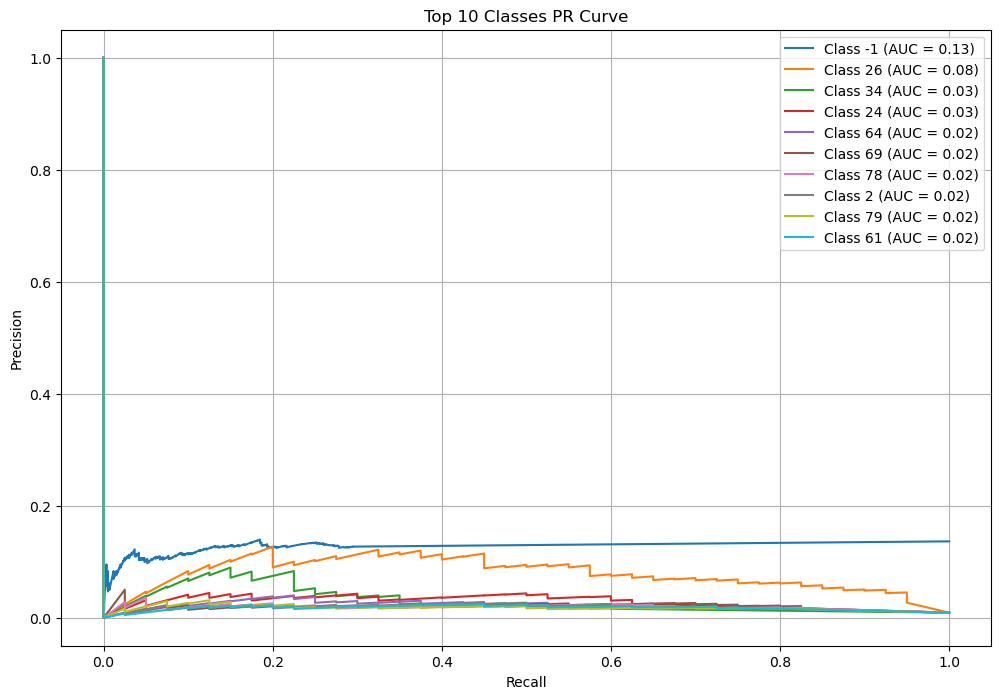

In [24]:
from sklearn.metrics import precision_recall_curve, auc
import matplotlib.pyplot as plt

# Function to plot the PR curves for the top N classes based on PR AUC
def plot_top_10_pr_curves(y_test, y_scores, n_classes, top_n=10):
    """
    Plots the Precision-Recall (PR) curves for the top N classes with the highest PR AUC.

    Parameters:
    - y_test: Ground truth labels for the test set.
    - y_scores: Predicted probabilities for each class.
    - n_classes: Total number of classes (including monitored and unmonitored).
    - top_n: Number of classes with the highest PR AUC to plot.

    Returns:
    - A plot showing the PR curves of the top N classes.
    """
    pr_auc_scores = []  # List to store PR AUC scores for all classes

    # Compute PR AUC for each class
    for i in range(n_classes):
        label = -1 if i == n_classes - 1 else i  # Label the last class as -1 for unmonitored
        binary_y_test = (y_test == label).astype(int)  # Convert to binary labels for the current class
        precision, recall, _ = precision_recall_curve(binary_y_test, y_scores[:, i])  # Compute PR curve
        pr_auc = auc(recall, precision)  # Calculate PR AUC
        pr_auc_scores.append((label, pr_auc))  # Append the label and AUC

    # Sort classes by PR AUC in descending order
    pr_auc_scores.sort(key=lambda x: x[1], reverse=True)
    top_classes = pr_auc_scores[:top_n]  # Select the top N classes

    # Plot PR curves for the top N classes
    plt.figure(figsize=(12, 8))
    for class_label, pr_auc in top_classes:
        binary_y_test = (y_test == class_label).astype(int)  # Binary labels for the current class
        precision, recall, _ = precision_recall_curve(binary_y_test, y_scores[:, class_label])  # PR curve
        plt.plot(recall, precision, label=f'Class {class_label} (AUC = {pr_auc:.2f})')  # Plot with label

    # Customize plot
    plt.title(f'Top {top_n} Classes PR Curve')  # Plot title
    plt.xlabel('Recall')  # X-axis label
    plt.ylabel('Precision')  # Y-axis label
    plt.legend(loc='best')  # Add legend to show class labels and AUCs
    plt.grid(True)  # Enable grid
    plt.show()  # Display plot

# Example usage
n_classes = 96  # Total classes (95 monitored + 1 unmonitored)
y_scores = rf_model.predict_proba(X_test)  # Predicted probabilities from the model
plot_top_10_pr_curves(y_test, y_scores, n_classes, top_n=10)  # Plot PR curves for top 10 classes


### 7-3. ROC Curve

/var/folders/f2/50xvdpsj2hjgtr8lbxtb3hkm0000gn/T/ipykernel_85440/3056364948.py:29: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab20', n_classes)
/var/folders/f2/50xvdpsj2hjgtr8lbxtb3hkm0000gn/T/ipykernel_85440/3056364948.py:39: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


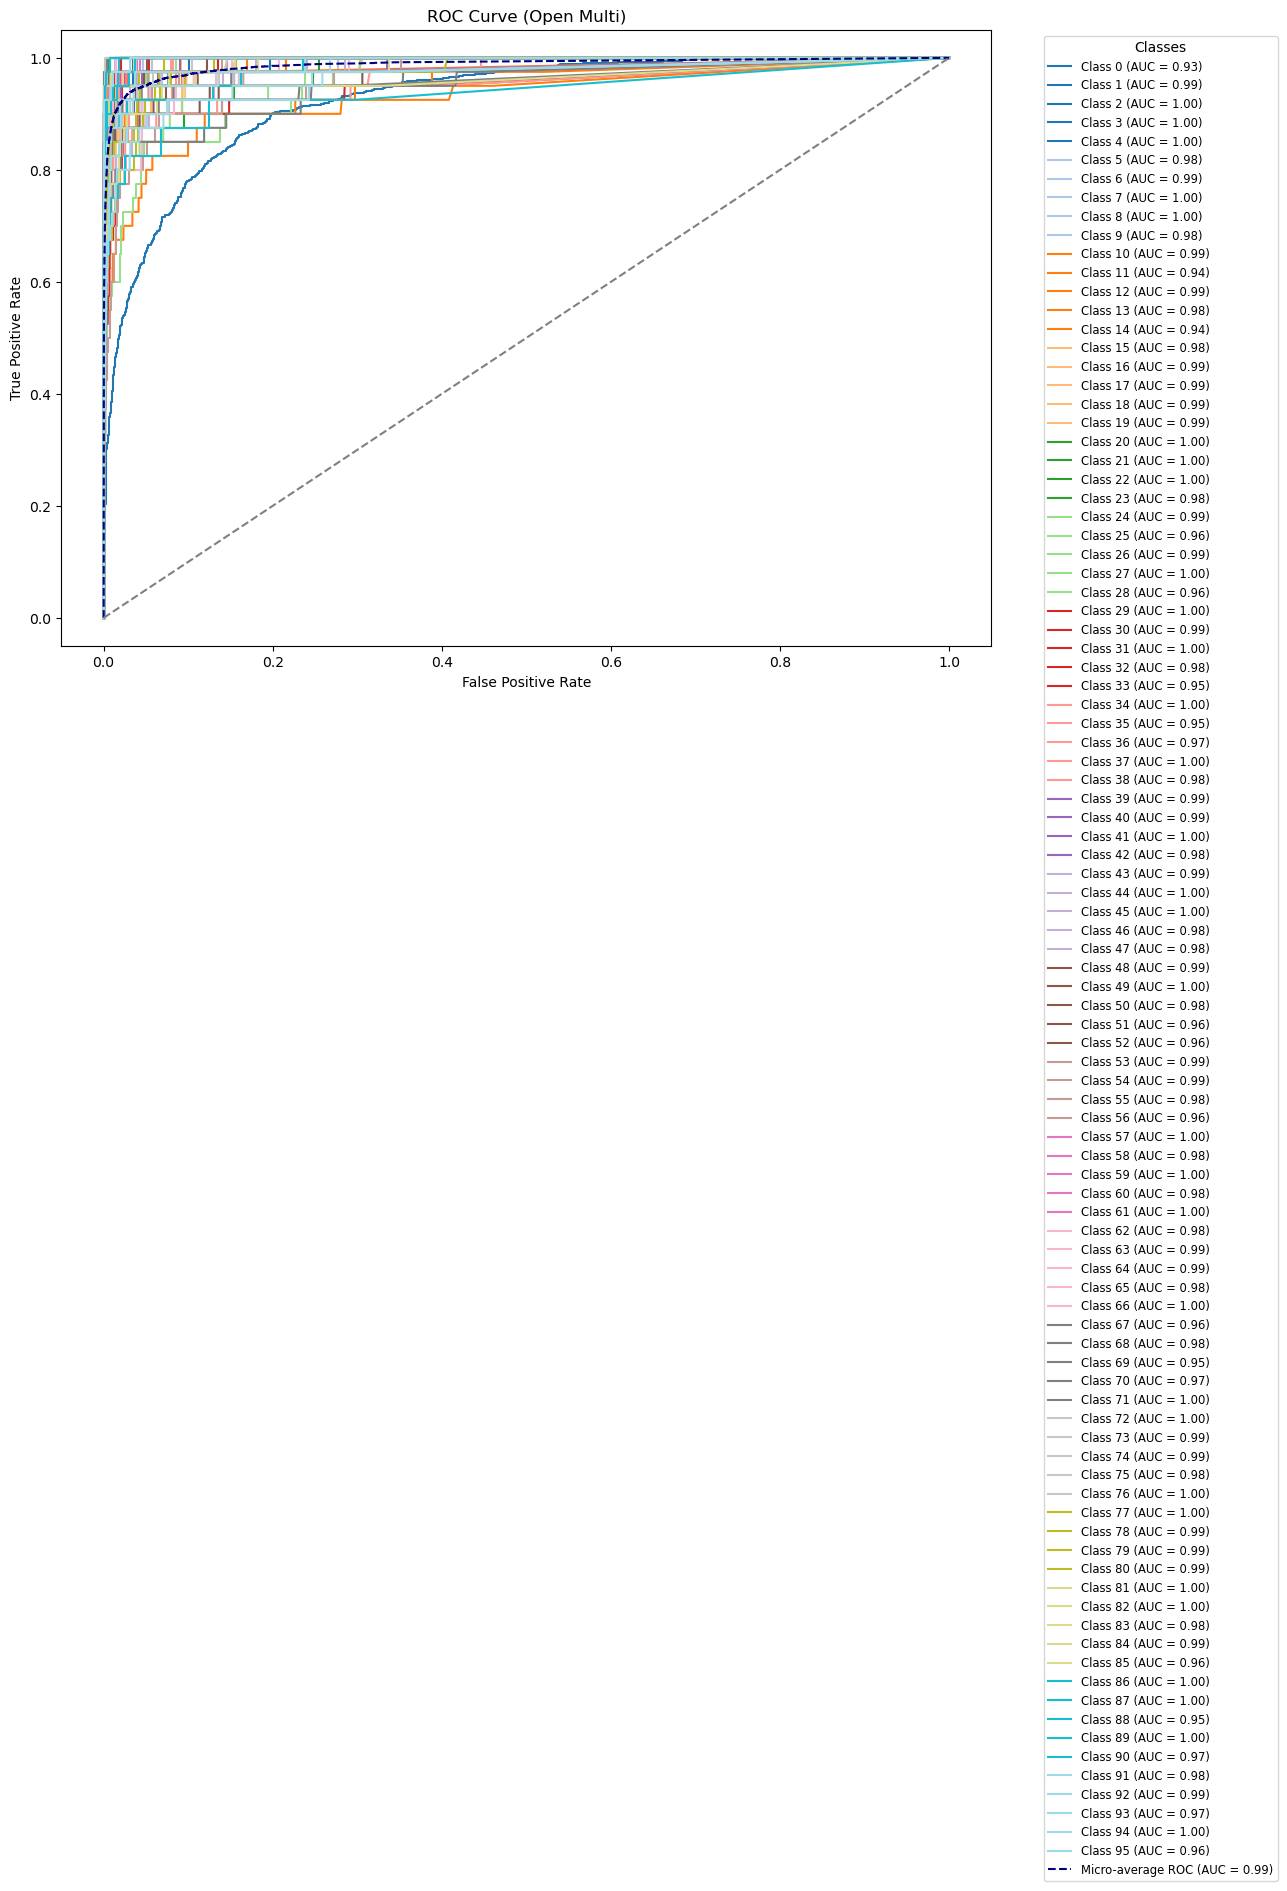

Micro-average AUC: 0.99
Macro-average AUC: 0.98


In [26]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np

# Binarize the test labels for multi-class ROC computation
y_test_bin = label_binarize(y_test, classes=np.unique(y))  # Convert labels to one-hot encoding
y_scores = rf_model.predict_proba(X_test)  # Predicted probabilities for each class
n_classes = y_test_bin.shape[1]  # Number of classes

# Initialize dictionaries to store FPR, TPR, and AUC for each class
fpr = {}
tpr = {}
roc_auc = {}

# Compute ROC curve and AUC for each class
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_scores[:, i])  # FPR, TPR, and thresholds
    roc_auc[i] = auc(fpr[i], tpr[i])  # Compute AUC for the current class

# Compute micro-average ROC and AUC
fpr_micro, tpr_micro, _ = roc_curve(y_test_bin.ravel(), y_scores.ravel())  # Flatten arrays
roc_auc_micro = auc(fpr_micro, tpr_micro)

# Compute macro-average AUC
roc_auc_macro = np.mean(list(roc_auc.values()))  # Average AUC across all classes

# Plot ROC curves for each class and the micro-average
plt.figure(figsize=(12, 8))
colors = plt.cm.get_cmap('tab20', n_classes)  # Generate a color map for the classes
for i in range(n_classes):
    plt.plot(
        fpr[i], tpr[i], 
        label=f'Class {i} (AUC = {roc_auc[i]:.2f})', 
        color=colors(i / n_classes)
    )

# Plot micro-average ROC curve
plt.plot(fpr_micro, tpr_micro, label=f'Micro-average ROC (AUC = {roc_auc_micro:.2f})', color='navy', linestyle='--')

# Plot diagonal reference line
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')

# Add labels, title, and legend
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (Open Multi)')
plt.legend(loc='best', bbox_to_anchor=(1.05, 1), fontsize='small', title="Classes")
plt.tight_layout()  # Adjust layout for better display
plt.show()

# Print micro-average and macro-average AUC
print(f"Micro-average AUC: {roc_auc_micro:.2f}")
print(f"Macro-average AUC: {roc_auc_macro:.2f}")


In [27]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

def compute_macro_roc_auc(y_test, y_scores, n_classes):
    """
    Computes the macro-average ROC AUC across all classes in a multi-class classification task.

    """
    # Binarize the test labels into a one-hot encoded format
    y_test_bin = label_binarize(y_test, classes=np.arange(n_classes))

    roc_auc_per_class = []  # List to store ROC AUC values for each class

    # Compute ROC AUC for each class
    for i in range(n_classes):
        if np.sum(y_test_bin[:, i]) == 0:  # Skip classes with no samples in y_test
            print(f"Class {i} has no samples in y_test. Skipping...")
            continue
        fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_scores[:, i])  # FPR and TPR for the current class
        roc_auc = auc(fpr, tpr)  # Compute AUC
        roc_auc_per_class.append(roc_auc)  # Append the ROC AUC for the class

    # Compute macro-average ROC AUC by averaging AUC values across classes
    macro_roc_auc = np.mean(roc_auc_per_class)

    # Print class-wise and macro-average ROC AUC
    print(f"ROC AUC for each class: {roc_auc_per_class}")
    print(f"Macro-average ROC AUC: {macro_roc_auc:.4f}")


# Define the number of classes (monitored + unmonitored)
n_classes = 96

# Call the function with test labels and predicted probabilities
compute_macro_roc_auc(y_test, rf_model.predict_proba(X_test), n_classes)


Class 95 has no samples in y_test. Skipping...
ROC AUC for each class: [0.5576949541284404, 0.423125, 0.7054558486238532, 0.5272219036697249, 0.390493119266055, 0.5143033256880735, 0.6361525229357798, 0.6252178899082569, 0.6030160550458716, 0.5506336009174313, 0.40443520642201847, 0.3153899082568808, 0.5439478211009174, 0.555493119266055, 0.5668061926605505, 0.7125974770642203, 0.3830991972477064, 0.3974311926605505, 0.36770068807339457, 0.4121674311926605, 0.5212815366972476, 0.42039564220183484, 0.37277522935779817, 0.3588675458715596, 0.7296788990825689, 0.5375688073394496, 0.9116284403669724, 0.44189220183486244, 0.4964621559633027, 0.47515194954128437, 0.5218520642201834, 0.47542144495412836, 0.37419724770642204, 0.5746072247706423, 0.6667316513761468, 0.4957196100917431, 0.41691800458715594, 0.5064392201834863, 0.4082339449541285, 0.5160120412844037, 0.5417803899082568, 0.45681479357798177, 0.585805619266055, 0.3250258027522936, 0.3599770642201835, 0.46497706422018353, 0.45123853

### 7.4 Performance Variation with Threshold Changes

/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall

Best threshold based on F1 score: 0.05


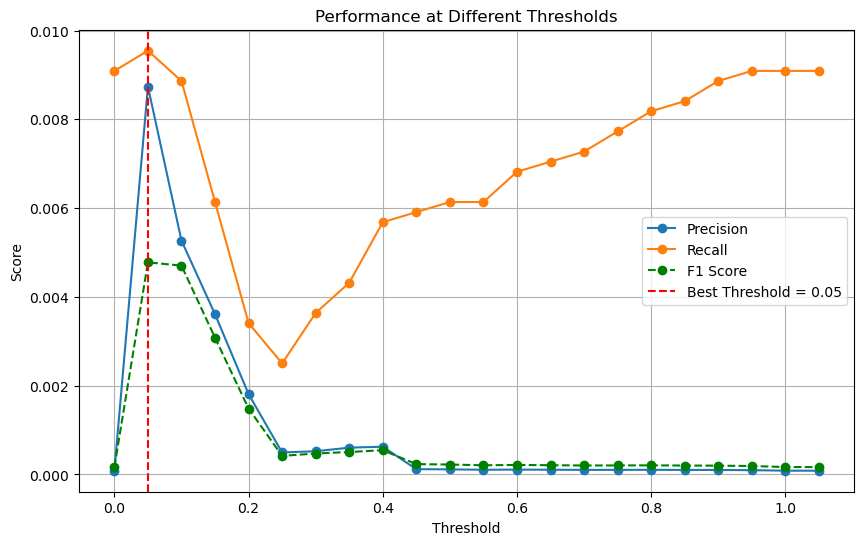

In [30]:
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score
import matplotlib.pyplot as plt

def plot_threshold_performance(y_test, y_scores):
    """
    Plots the precision, recall, and F1 score at different decision thresholds for a multi-class classification task.
    
    """
    # Define threshold values to evaluate (0.0 to 1.0 in increments of 0.05)
    thresholds = np.arange(0.0, 1.1, 0.05)

    # Initialize lists to store precision, recall, and F1 scores
    precision_vals = []
    recall_vals = []
    f1_vals = []

    # Iterate over each threshold
    for threshold in thresholds:
        # Predict class labels based on the current threshold
        y_pred = np.argmax(y_scores >= threshold, axis=1)

        # Compute weighted precision, recall, and F1 scores
        precision_vals.append(precision_score(y_test, y_pred, average='weighted', zero_division=0))
        recall_vals.append(recall_score(y_test, y_pred, average='weighted'))
        f1_vals.append(f1_score(y_test, y_pred, average='weighted'))

    # Identify the best threshold based on the highest F1 score
    best_threshold = thresholds[np.argmax(f1_vals)]
    print("Best threshold based on F1 score:", best_threshold)

    # Plot precision, recall, and F1 score at different thresholds
    plt.figure(figsize=(10, 6))
    plt.plot(thresholds, precision_vals, label='Precision', marker='o')
    plt.plot(thresholds, recall_vals, label='Recall', marker='o')
    plt.plot(thresholds, f1_vals, label='F1 Score', marker='o', linestyle='--', color='g')
    plt.axvline(x=best_threshold, color='red', linestyle='--', label=f'Best Threshold = {best_threshold:.2f}')
    plt.xlabel('Threshold')
    plt.ylabel('Score')
    plt.title('Performance at Different Thresholds')
    plt.legend(loc='best')
    plt.grid(True)
    plt.show()


# Get predicted probabilities from the model
y_scores = rf_model.predict_proba(X_test)

# Plot performance at different thresholds
plot_threshold_performance(y_test, y_scores)
